In [ ]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision.io import read_image
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import time
import copy
import os
import sys

In [ ]:
!unzip '/content/drive/MyDrive/Spring 2021/CS 182/tiny-imagenet-200.zip'

In [4]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # for layer 0
        self.conv = nn.Conv2d(3, 32, kernel_size=3, stride=1,
                              padding=1, bias=False)
  
        self.relu = nn.ReLU(inplace=True)
        
        # for layer 1
        self.conv_1 = nn.Conv2d(32, 128, kernel_size=3, stride=1, 
                                padding=1, bias=False)
        # for layer 2 - 4
        self.conv_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, 
                                padding=1, bias=False)
        
        # for layer 6
        self.conv_3 = nn.Conv2d(160, 256, kernel_size=3, stride=1, 
                                padding=1, bias=False)
        # for layer 7 - 9
        self.conv_4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, 
                                padding=1, bias=False)
        # for layer 11
        self.conv_5 = nn.Conv2d(416, 512, kernel_size=3, stride=1, 
                                padding=1, bias=False)
        # for layer 12 - 14
        self.conv_6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, 
                                padding=1, bias=False)
        
        # for layer 16
        self.conv_7 = nn.Conv2d(928, 200, kernel_size=1, stride=1, 
                                padding=1, bias=False)
        
        self.bn_32 = nn.BatchNorm2d(32)
        self.bn_128 = nn.BatchNorm2d(128)
        self.bn_160 = nn.BatchNorm2d(160)
        self.bn_256 = nn.BatchNorm2d(256)
        self.bn_416 = nn.BatchNorm2d(416)
        self.bn_512 = nn.BatchNorm2d(512)
        self.bn_928 = nn.BatchNorm2d(928)


        self.max_pool = nn.MaxPool2d(2, stride=2)
        
        self.avg_pool = nn.AvgPool2d(8)
    
    def forward(self, x):
        # block 1, layer 0
        layer0 = self.conv(x)
        layer0 = self.bn_32(layer0)
        layer0 = self.relu(layer0)
        skip_connection_1 = layer0
        
        # block 2, layer 1 - 5
        # layer 1
        layer1 = self.conv_1(layer0)
        layer1 = self.bn_128(layer1)
        layer1 = self.relu(layer1)
        # layer 2 - 4
        out = layer1
        for _ in range(3):
            out = self.conv_2(out)
            out = self.bn_128(out)
            out = self.relu(out)
        layer4 = out
        # layer 5
        layer5 = torch.cat((skip_connection_1, layer4), 1)
        layer5 = self.bn_160(layer5)
        layer5 = self.relu(layer5)
        layer5 = self.max_pool(layer5)
        skip_connection_2 = layer5
        
        # block 3, layer 6 - 10
        # layer 6
        layer6 = self.conv_3(layer5)
        layer6 = self.bn_256(layer6)
        layer6 = self.relu(layer6)
        # layer 7 - 9
        out = layer6
        for _ in range(3):
            out = self.conv_4(out)
            out = self.bn_256(out)
            out = self.relu(out)
        layer9 = out
        # layer 10
        layer10 = torch.cat((skip_connection_2, layer9), 1)
        layer10 = self.bn_416(layer10)
        layer10 = self.relu(layer10)
        layer10 = self.max_pool(layer10)
        skip_connection_3 = layer10
        
        # block 4, layer 11 - 15
        # layer 11
        layer11 = self.conv_5(layer10)
        layer11 = self.bn_512(layer11)
        layer11 = self.relu(layer11)
        # layer 12 - 14
        out = layer11
        for _ in range(3):
            out = self.conv_6(out)
            out = self.bn_512(out)
            out = self.relu(out)
        layer14 = out
        # layer 15
        layer15 = torch.cat((skip_connection_3, layer14), 1)
        layer15 = self.bn_928(layer15)
        layer15 = self.relu(layer15)
        layer15 = self.max_pool(layer15)
        
        # layer 16 and output
        layer16 = self.conv_7(layer15)
        out = self.avg_pool(layer16)
        out = out.view(out.size(0), -1)
        return out
    

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, val_label_dir, img_dir, train_path, transform=None, target_transform=None):
        super(CustomImageDataset, self).__init__()
        self.val_label_file = pd.read_csv(val_label_dir, delimiter = "\t", names=["pics", "labels", "_1", "_2", "_3", "_4"])
        self.img_labels = self.val_label_file[["pics", 'labels']]
        self.img_dir = img_dir
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(train_path)

    def __len__(self):
        return len(self.img_labels)

    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.
        Args:
            dir (string): Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.
        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def pad(self, img):
        padding = np.ones((64, 64, 2))
        img = img.reshape((64, 64, 1))
        img = np.concatenate((img, padding), axis=2)
        return img.astype(np.float32)
      
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = Image.open(img_path)
        img = copy.deepcopy(np.asarray(img))
        # if it has less than 3 channels
        if img.shape != (64, 64, 3):
            img = self.pad(img)
        #print(img.shape)
        label = self.img_labels.iloc[idx, 1]
        label = self.class_to_idx[label]
        if self.transform:
            img = self.transform(img)
        #sample = {"image": img, "label": label}
        return img, label

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/tiny-imagenet-200'

val_label_dir = '/content/tiny-imagenet-200/val/val_annotations.txt'

image_datasets = {}

image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])

image_datasets['val'] = CustomImageDataset(val_label_dir, data_dir+'/val/images', 
                                           os.path.join(data_dir, 'train'),
                                           transform=data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=2)
                                            for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#x, y = next(iter(image_datasets['val']))
#print(x, y)

In [16]:
# No pretrained parameters
#model = CustomNet()
model = models.resnet18(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(1)

# Modify the output class number
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.maxpool = nn.Sequential()
model = model.to(device)

#Multi GPU
#model = torch.nn.DataParallel(model, device_ids=[0, 1])

#Loss Function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)), end="")
                sys.stdout.flush()
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                avg_loss = epoch_loss
                t_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        liveloss.update({
            'log loss': avg_loss,
            'val_log loss': val_loss,
            'accuracy': t_acc,
            'val_accuracy': val_acc
        })
                
        liveloss.draw()
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, t_acc))
        print(  'Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print('Best Val Accuracy: {}'.format(best_acc))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

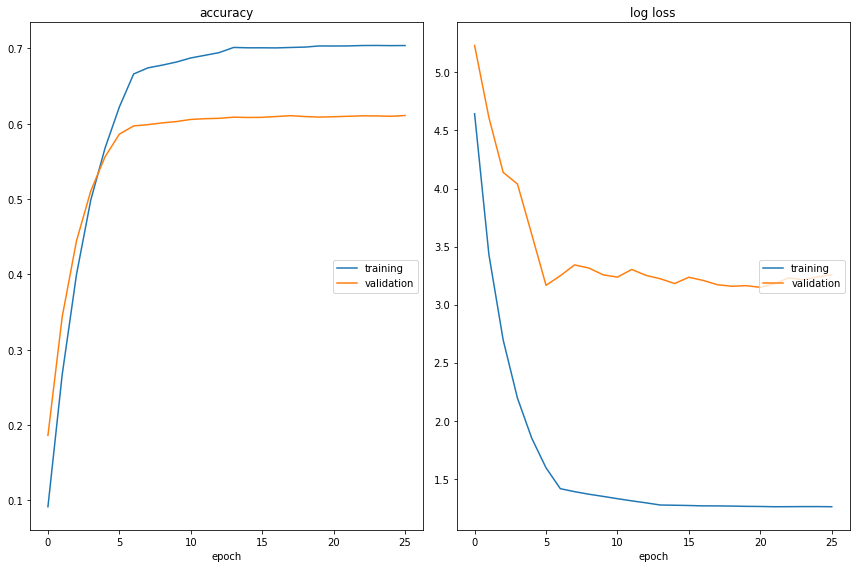

accuracy
	training         	 (min:    0.092, max:    0.704, cur:    0.704)
	validation       	 (min:    0.186, max:    0.611, cur:    0.611)
log loss
	training         	 (min:    1.259, max:    4.643, cur:    1.259)
	validation       	 (min:    3.149, max:    5.232, cur:    3.258)
Train Loss: 1.2593 Acc: 0.7038
Val Loss: 3.2578 Acc: 0.6109
Best Val Accuracy: 0.6109

Epoch 27/50
----------
Iteration: 164/782, Loss: 167.76734924316406.

In [ ]:
model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Sequential()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,